## Generate images with text conditioning

Now we will load the model checkpoint, update the sampling logic to handle text embeddings, and experiment with different text prompts, guidance scales, and random seeds.

### Updating the sampling logic to handle classifier-free guidance

We will run the denoising model in both conditional and unconditional modes: one with the text embeddings and one with the null embeddings. This can be done in a single forward pass by concatenating the text embeddings with the null embeddings. Then we can split the output into two parts, and compute the guidance by subtracting the two parts.

The following code is the main change:

```python
    # Double the batch - first half conditioned on text, second half unconditioned
    x_twice = torch.cat([x_t] * 2)
    t_twice = torch.cat([t_tensor] * 2)
    
    # Create unconditional embeddings (null text embeddings) and concatenate with text embeddings
    if text_embeddings is not None:
        uncond_embeddings = denoising_model.get_null_text_embed(batch_size=x_t.shape[0])
        embeddings_cat = torch.cat([uncond_embeddings, text_embeddings])
    else:
        embeddings_cat = None

    with torch.no_grad():
        model_output = denoising_model(t=t_twice, x=x_twice, text_embeddings=embeddings_cat)

    # Split predictions and perform guidance
    noise_pred_uncond, noise_pred_text = model_output.chunk(2)
    adjustment = guidance_scale * (noise_pred_text - noise_pred_uncond)
    model_output = noise_pred_uncond + adjustment
```


In [1]:
import torch
from tqdm.auto import tqdm


def denoising_step(denoising_model, x_t, t, noise_schedule, text_embeddings=None, thresholding=False, clip_sample=True, clip_sample_range=1.0, guidance_scale=7.5):
    """
    This is the backward diffusion step, with the effect of denoising.
    Implements classifier-free guidance by conditioning on both text embeddings and unconditional (null) embeddings.
    """
    if isinstance(t, int):
        t_tensor = torch.full((x_t.shape[0],), t, device=x_t.device)
    else:
        t_tensor = t

    # Double the batch - first half conditioned on text, second half unconditioned
    x_twice = torch.cat([x_t] * 2)
    t_twice = torch.cat([t_tensor] * 2)
    
    # Create unconditional embeddings (zeros) and concatenate with text embeddings
    if text_embeddings is not None:
        uncond_embeddings = denoising_model.get_null_text_embed(batch_size=x_t.shape[0])
        embeddings_cat = torch.cat([uncond_embeddings, text_embeddings])
    else:
        embeddings_cat = None

    with torch.no_grad():
        model_output = denoising_model(t=t_twice, x=x_twice, text_embeddings=embeddings_cat)
    if hasattr(model_output, "sample"):
        model_output = model_output.sample

    # Split predictions and perform guidance
    noise_pred_uncond, noise_pred_text = model_output.chunk(2)
    adjustment = guidance_scale * (noise_pred_text - noise_pred_uncond)
    # print("avg adjustment", adjustment.cpu().numpy().mean(), "guidance scale", guidance_scale)
    model_output = noise_pred_uncond + adjustment

    # Extract relevant values from noise_schedule
    alpha_prod_t = noise_schedule["alphas_cumprod"][t_tensor]
    # deal with t=0 case where t can be a tensor
    alpha_prod_t_prev = torch.where(t_tensor > 0,
                                    noise_schedule["alphas_cumprod"][t_tensor - 1],
                                    torch.ones_like(t_tensor, device=x_t.device))

    # Reshape alpha_prod_t_prev for proper broadcasting
    alpha_prod_t = alpha_prod_t.view(-1, 1, 1, 1)
    alpha_prod_t_prev = alpha_prod_t_prev.view(-1, 1, 1, 1)

    beta_prod_t = 1 - alpha_prod_t
    beta_prod_t_prev = 1 - alpha_prod_t_prev
    current_alpha_t = alpha_prod_t / alpha_prod_t_prev
    current_beta_t = 1 - current_alpha_t

    # Compute the previous sample mean
    pred_original_sample = (x_t - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5

    if clip_sample:
        pred_original_sample = torch.clamp(pred_original_sample, -clip_sample_range, clip_sample_range)

    # Compute the coefficients for pred_original_sample and current sample
    pred_original_sample_coeff = (alpha_prod_t_prev ** 0.5 * current_beta_t) / beta_prod_t
    current_sample_coeff = current_alpha_t ** 0.5 * beta_prod_t_prev / beta_prod_t

    # Compute the previous sample
    pred_prev_sample = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * x_t

    # Add noise
    variance = torch.zeros_like(x_t)
    variance_noise = torch.randn_like(x_t)

    # Handle t=0 case where t can be a tensor
    non_zero_mask = (t_tensor != 0).float().view(-1, 1, 1, 1)
    variance = non_zero_mask * ((1 - alpha_prod_t_prev) / (1 - alpha_prod_t) * current_beta_t)
    variance = torch.clamp(variance, min=1e-20)

    pred_prev_sample = pred_prev_sample + (variance ** 0.5) * variance_noise

    return pred_prev_sample


def generate_samples_by_denoising(denoising_model, x_T, text_embeddings, guidance_scale, noise_schedule, n_T, device, thresholding=False, clip_sample=True, clip_sample_range=1.0, seed=0):
    """
    This is the generation process.
    """
    torch.manual_seed(seed)

    x_t = x_T.to(device)
    pbar = tqdm(range(n_T - 1, -1, -1))
    for t in pbar:
        x_t = denoising_step(
            denoising_model=denoising_model,
            x_t=x_t,
            t=t,
            noise_schedule=noise_schedule,
            text_embeddings=text_embeddings,
            guidance_scale=guidance_scale,
            thresholding=thresholding,
            clip_sample=clip_sample,
            clip_sample_range=clip_sample_range,
        )
        pbar.set_postfix({"std": x_t.std().item()})

    # print("raw x_t range", x_t.min(), x_t.max())
    x_t = (x_t / 2 + 0.5).clamp(0, 1)
    # print("after clamp", x_t.min(), x_t.max())
    return x_t

In [2]:
import torch
import torch.nn as nn
from transformers import CLIPTextModel, CLIPTokenizer


class TextEncoder(nn.Module):
    def __init__(self, model_name: str, device: str):
        super().__init__()
        self.model_name = model_name
        self.model = CLIPTextModel.from_pretrained(model_name).to(device)
        self.tokenizer = CLIPTokenizer.from_pretrained(model_name)
        self.device = device
        # Get the text embedding dimension from the config
        self.text_embed_dim = self.model.config.hidden_size

    def forward(self, text: str) -> torch.Tensor:
        tokens = self.tokenizer(text, padding=True, truncation=True, return_tensors="pt").to(self.device)
        return self.model(**tokens).pooler_output

2024-12-31 20:33:28.554334: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-31 20:33:28.567927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-31 20:33:28.583236: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-31 20:33:28.587863: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-31 20:33:28.599387: I tensorflow/core/platform/cpu_feature_guar

### Load the checkpoint

In [3]:
from lib_4_1.diffusion import create_noise_schedule
from lib_4_1.model import create_unet_model
from lib_4_1.config import TrainingConfig
# generate images with text conditioning
# load the model
config = TrainingConfig(dataset="reese-green/afhq64_captions_64k", caption_column="caption_blip2-opt-2.7b", batch_size=8, resolution=32)
denoising_model = create_unet_model(config, config.device)
denoising_model.load_state_dict(torch.load("denoising_model_4_1.pth", map_location="cuda:0"))
denoising_model.eval()
text_encoder = TextEncoder("openai/clip-vit-large-patch14", "cuda:0")
text_encoder.eval()

noise_schedule = create_noise_schedule(n_T=1000, device="cuda:0")

model params: 14.68 M


/tmp/ipykernel_910080/1043077838.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  denoising_model.load_state_dict(torch.load("denoising_model_4_1.pth", map_location="cuda

### Text prompts

We will use 2 empty text prompts, and another 2 text prompts describing animals. These texts are encoded into text embeddings.

We then force the first text embedding to be the learned null embedding. The second text prompt is an empty string, but its embedding is different from the null embedding. When the guidance scale varies from 0 to a larger value, do the generated images change? How do they change?

In [4]:
texts = ["null", "", "a black cat with a lot of fur", "a male lion"]
with torch.no_grad():
    text_embeddings = text_encoder(texts)
print(text_embeddings.shape)
# TODO: for empty text, set the text_embeddings to null_embedding
try:
    text_embeddings[0] = denoising_model.get_null_text_embed()
except Exception as e:
    print("Error: get_null_text_embed is not defined in the denoising_model")
    print(e)

torch.Size([4, 768])


### Utility function to generate and show images

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def generate_and_show(**kwargs):
    torch.manual_seed(0)
    a = generate_samples_by_denoising(
        denoising_model=denoising_model,
        x_T=torch.randn(len(texts), 3, 32, 32),
        text_embeddings=text_embeddings,
        # guidance_scale=0,
        noise_schedule=noise_schedule,
        n_T=1000,
        device="cuda:0",
        # seed=10,
        **kwargs,
    )

    
    # display images
    # convert from cuda to cpu
    a = a.cpu()
    # convert from torch to numpy
    a = a.numpy()
    # convert from (C, H, W) to (H, W, C)
    a = np.transpose(a, (0, 2, 3, 1))

    # make the figure a bit taller
    fig, axes = plt.subplots(2, 2, figsize=(6, 7))
    axes = axes.ravel()
    for i in range(4):
        axes[i].imshow(a[i])
        axes[i].set_title(texts[i])
    plt.tight_layout()
    # a caption for the whole figure
    plt.suptitle(f"Guidance scale: {kwargs.get('guidance_scale', 0)}, Seed: {kwargs.get('seed', 0)}")
    plt.show()

### Generate images with no text conditioning

  0%|          | 0/1000 [00:00<?, ?it/s]

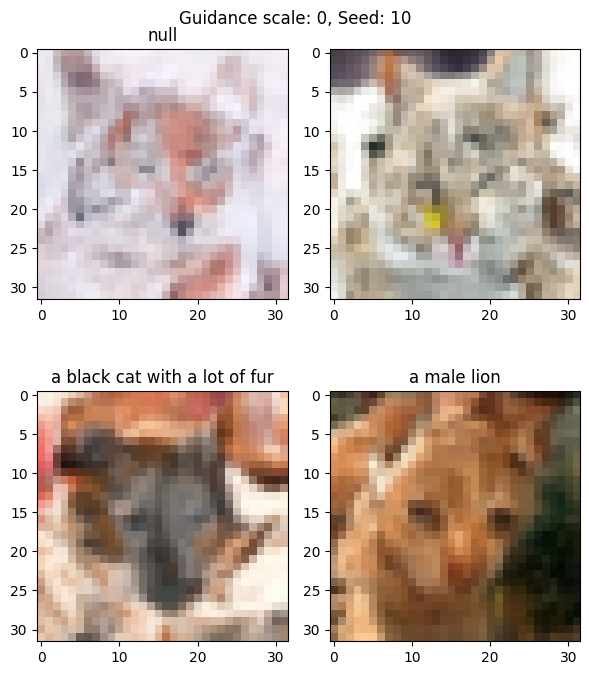

In [6]:
# generate samples
generate_and_show(
    guidance_scale=0, seed=10,
)

### Generate images with text conditioning (guidance_scale=7)

  0%|          | 0/1000 [00:00<?, ?it/s]

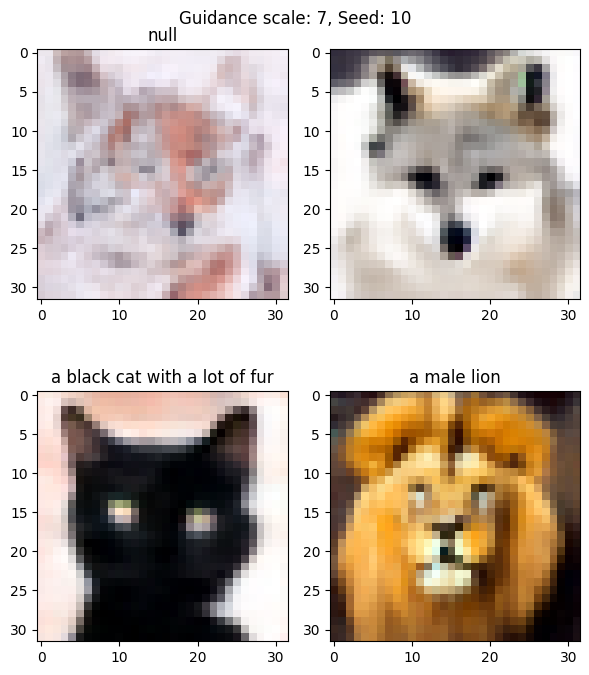

In [7]:
# generate samples
generate_and_show(
    guidance_scale=7, seed=10,
)

### Now try a different random seed

  0%|          | 0/1000 [00:00<?, ?it/s]

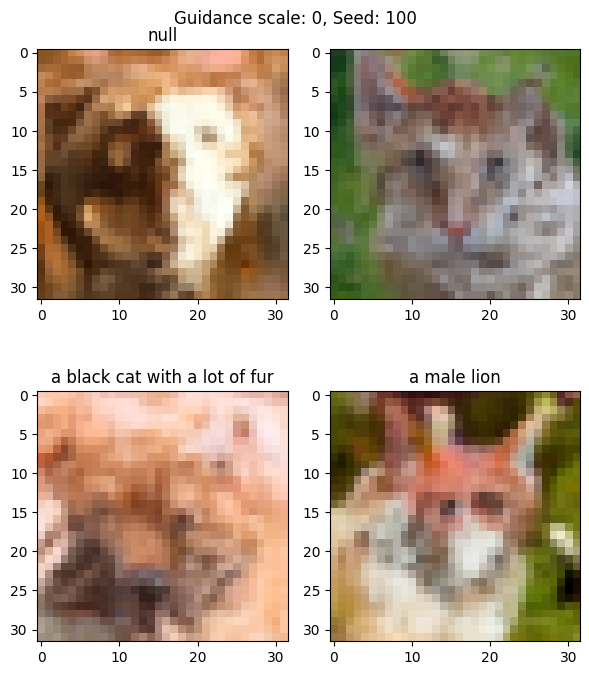

In [8]:
generate_and_show(
    guidance_scale=0, seed=100,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

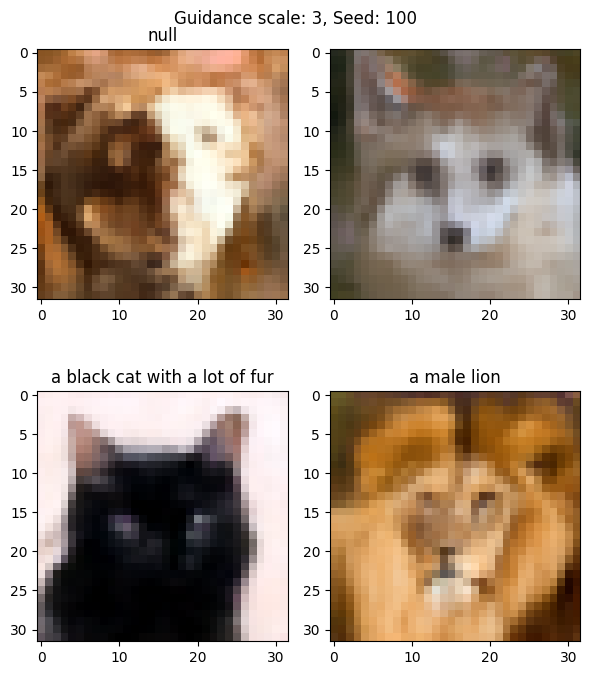

In [9]:
generate_and_show(
    guidance_scale=3, seed=100,
)


  0%|          | 0/1000 [00:00<?, ?it/s]

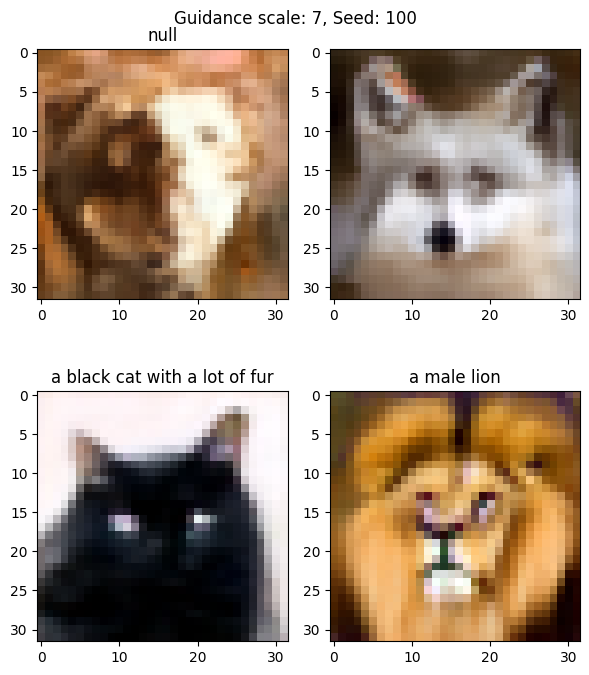

In [10]:
generate_and_show(
    guidance_scale=7, seed=100,
)


  0%|          | 0/1000 [00:00<?, ?it/s]

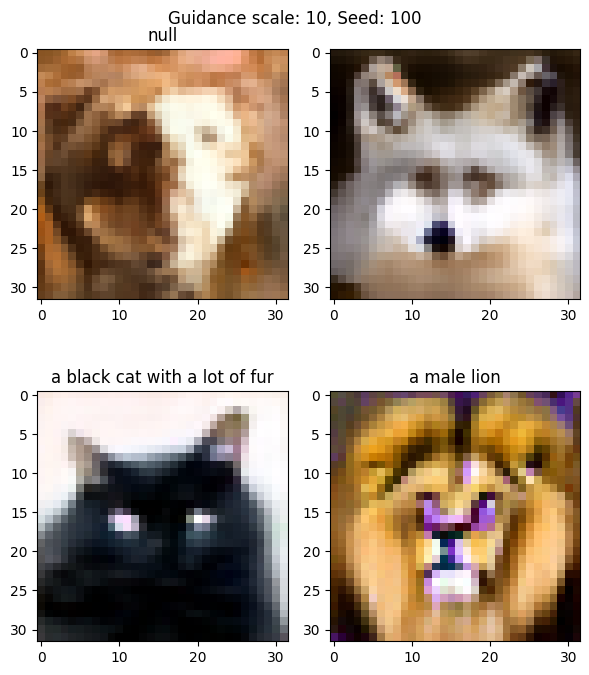

In [11]:
generate_and_show(
    guidance_scale=10, seed=100,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

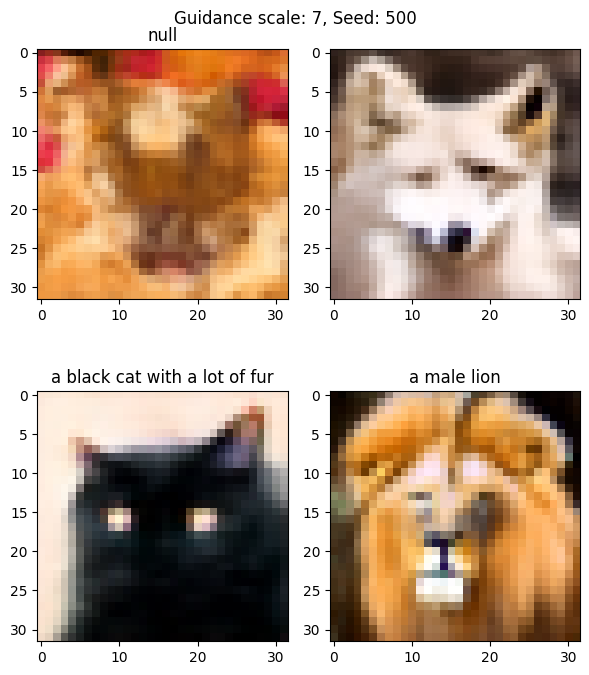

In [12]:
generate_and_show(
    guidance_scale=7, seed=500,
)


So the empty string is more like "wolf" than a random string. Is this an inherent property of the text encoder? For example, is the empty closer to "wolf" than "cat"?

In [13]:
import torch

concepts = ["", "a wolf", "a cat", "a lion", "a dog"]
with torch.no_grad():
    concept_embeddings = text_encoder(concepts)

# pairwise cosine similarity
cosine_similarity = torch.nn.functional.cosine_similarity(concept_embeddings[0], concept_embeddings[:], dim=1)
print(cosine_similarity)

# pairwise euclidean distance
euclidean_distance = torch.nn.functional.pairwise_distance(concept_embeddings[0], concept_embeddings[:])
print(euclidean_distance)


tensor([1.0000, 0.4773, 0.5562, 0.4810, 0.5907], device='cuda:0')
tensor([2.7713e-05, 2.9616e+01, 2.7415e+01, 2.9365e+01, 2.6354e+01],
       device='cuda:0')


Not really. So it remains a mystery.

Since we will make sure to replace an empty string with the null embedding, we don't need to worry about this in practice.